In [1]:
import numpy as np
from matplotlib import pyplot as plt
from SYK_fft import *
from ConformalAnalytical import *
import testingscripts

In [2]:
testingscripts.realtimeFFT_validator() # Should return True

True

In [3]:
def rhotosigma(rhoG,rhoD,M,dt,t,g,kappa=1,delta=1e-6):
    '''
    returns [Sigma,Pi] given rhos
    '''
    eta = np.pi/(M*dt)*(0.001)
    rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
    rhoFpp = (1/np.pi)*freq2time(rhoG * fermidirac(beta*omega),M,dt)
    rhoFpm = (1/np.pi)*freq2time(rhoG * fermidirac(-1.*beta*omega),M,dt)
    rhoFmp = (1/np.pi)*freq2time(rhoGrev * fermidirac(beta*(omega)),M,dt)
    rhoFmm = (1/np.pi)*freq2time(rhoGrev * fermidirac(-1.*beta*omega),M,dt)
    rhoBpp = (1/np.pi)*freq2time(rhoD * boseeinstein(beta*(omega+eta)),M,dt)
    rhoBpm = (1/np.pi)*freq2time(rhoD * boseeinstein(-1.*beta*(omega+eta)),M,dt)
    
    argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    #argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.heaviside(t,1)
    Sigma = 1j*(g**2)*kappa * time2freq(argSigma,M,dt)
    
    argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    #argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.heaviside(t,1)
    Pi = 2*1j*(g**2) * time2freq(argPi,M,dt)
    
    return [Sigma, Pi]

In [4]:
g = 0.5
mu = 0.
#r = 0.001
#r = 0. 
r = 1.

beta = 5.

M = int(2**18) #number of points in the grid
T = 2**12 #upper cut-off for the time
dt = (2*T)/((2*M))
t = dt * (np.arange(2*M) - M)

dw = np.pi/(M*dt)
#eta = 1.1011011101111011111 * dw * 0.1
#eta = dw*11.
#eta = dw*1.000001
eta = dw*0.01

omega = dw * (np.arange(2*M) - M) 
np.testing.assert_almost_equal(dt*dw*M,np.pi,5, "Error in fundamentals")
err = 1e-1
print("omega max = ", omega[-1], "dw = ", dw )
print("dt = ", dt)

delta = 0.420374134464041
np.testing.assert_almost_equal(np.max(np.abs(omega)),np.pi*M/T,5,"Error in creating omega grid")

omega max =  201.06116283935282 dw =  0.0007669903939428206
dt =  0.015625


In [5]:
#GRomega = (-1j)*np.ones(2*M)
#GRomega = time2freq((-1j)*np.ones(2*M)*np.heaviside(t,1.0),M,dt)
#GRomega = time2freq(GRconf(t+1j*delta,J = Jot,beta = beta),M,dt)
GRomega = 1/(omega + 1j*eta + mu)
#DRomega = 1/(-1.0*(omega + 1j*eta)**2 + r)
#DRomega = -1.0*np.ones(2*M)
#DRomega = time2freq(-1.0*np.ones(2*M)*np.heaviside(t,1.0),M,dt)
DRomega = DconfImag(-1j*(omega),g,beta)
#GRomega = GconfImag(-1j*(omega+1j*eta),g,beta)

itern = 0

omegar2 = ret_omegar2(g,beta)

diff = 1 
diffG,diffD = (0.5,0.5)
xG,xD = (0.5,0.5)


while (diff>err and itern<100): 
    itern += 1 
    diffoldG,diffoldD = (diffG,diffD)
    GRoldomega,DRoldomega = (1.0*GRomega, 1.0*DRomega)
    
    rhoG = -1.0*np.imag(GRomega)
    rhoD = -1.0*np.imag(DRomega)
    
    SigmaOmega,PiOmega = rhotosigma(rhoG,rhoD,M,dt,t,g,kappa=1,delta=eta)
    PiOmega[M] = 1.0*r - omegar2
    
#     if itern < 30 : 
#         PiOmega[M] = 1.0*r - omegar2
   
    GRomega = 1.0*xG/(omega + 1j*eta + mu - SigmaOmega) + (1-xG)*GRoldomega
    DRomega = 1.0*xD/(-1.0*(omega+1j*eta)**2 + r - PiOmega) + (1-xD)*DRoldomega
    
    GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
    DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)
    #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
    #DRt = DRt - np.imag(DRt) # make D(t) purely real
    #GRt[:M] = 0
    #DRt[:M] = 0
    #GRt[M] = -1j
    #DRt[M] = 0
    
    if itern > 40 :
        #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
        #DRt = DRt - np.imag(DRt) # make D(t) purely real
        GRt[:M] = 0
        DRt[:M] = 0
        #GRt[M] = -1j
        #DRt[M] = 0
    
    
    GRomega = time2freq(GRt,M,dt)
    DRomega = time2freq(DRt,M,dt)
    

   
    #diffG = np. sqrt((0.5/M) * np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
    #diffD = np. sqrt((0.5/M) * np.sum((np.abs(DRomega-DRoldomega))**2))
    diffG = np. sqrt(np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
    diffD = np. sqrt(np.sum((np.abs(DRomega-DRoldomega))**2))
    #diff = np.max([diffG,diffD])
    diff = 0.5*(diffG+diffD)
    diffG,diffD = diff,diff
    
    if diffG>diffoldG:
        xG/=2.
    if diffD>diffoldD:
        xD/=2.
    
    
    print("itern = ",itern, " , diff = ", diffG, diffD, " , x = ", xG, xD, end = '\r')
        



/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:87: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0 + np.exp(arg)))
/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:102: RuntimeWarning: overflow encountered in exp
  return (1.0/(np.exp(arg)-1))


In [6]:
GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)

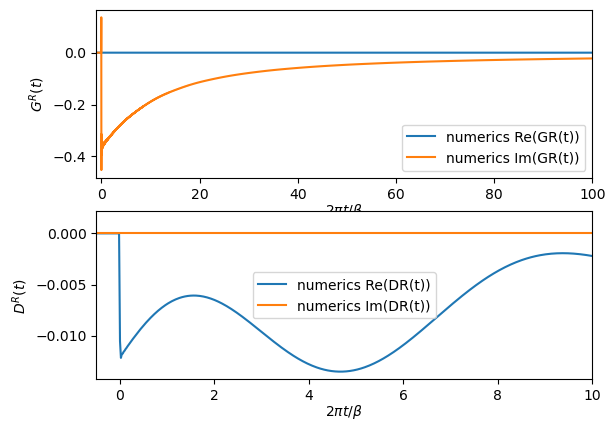

In [7]:
fig, ax = plt.subplots(2)

ax[0].plot(2*np.pi*t/beta, np.real(GRt), label = r'numerics Re(GR(t))')
ax[0].plot(2*np.pi*t/beta, np.imag(GRt), label = r'numerics Im(GR(t))')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-1,100)
ax[0].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[0].set_ylabel(r'${G^R(t)}$')
ax[0].legend()

ax[1].plot(2*np.pi*t/beta, np.real(DRt),'-',label = 'numerics Re(DR(t))')
ax[1].plot(2*np.pi*t/beta, np.imag(DRt), label = 'numerics Im(DR(t))')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[1].set_ylabel(r'${D^R(t)}$')
#ax[1].set_xlim(0,beta/(2*np.pi))
ax[1].set_xlim(-0.5,10)
ax[1].legend()


(-6.373801657793411e-05-1.26298635298413e-09j)


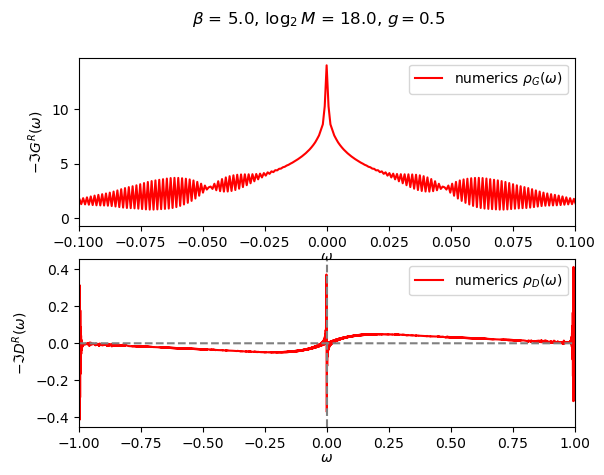

In [8]:
fig, ax = plt.subplots(2)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $g = $' + str(g)
fig.suptitle(titlestring)

ax[0].plot(omega, rhoG, 'r', label = r'numerics $\rho_G(\omega)$')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-0.1,0.1)
ax[0].set_xlabel(r'$\omega$',labelpad = 0)
ax[0].set_ylabel(r'$-\Im{G^R(\omega)}$')
ax[0].legend()

ax[1].plot(omega, rhoD, 'r', label = r'numerics $\rho_D(\omega)$')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
#ax[1].plot(omega,rhoD*boseeinstein(beta*omega), label = 'density of states')
ax[1].set_xlabel(r'$\omega$',labelpad = 0)
ax[1].set_ylabel(r'$-\Im{D^R(\omega)}$')
ax[1].set_xlim(-1,1)
ax[1].legend()
ax[1].plot(omega, np.zeros_like(omega),ls = '--', c = 'gray')
ax[1].axvline([0], ls = '--', c = 'gray')

print(DRomega[-1])

In [9]:
dw, 1/beta 

(0.0007669903939428206, 0.2)

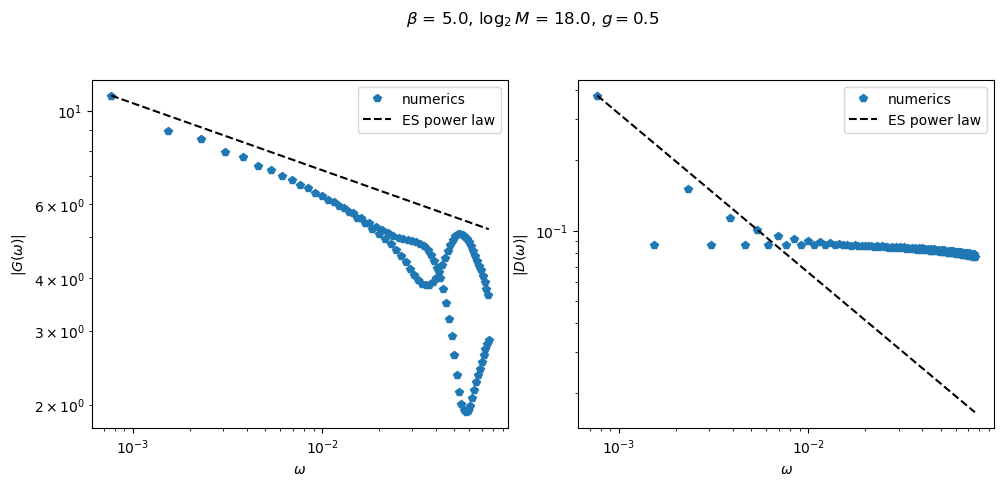

In [10]:
# powD = 1. - 4*Delta
delta = 0.420374134464041
start,stop = M+1, M+100

#fitG_val = -np.imag(GRomega[start])
#conf_fit_G = 1 * np.abs(omega+1j*eta)**(2*delta - 1)
#conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val
#alt_conf_fit_G = fitG_val * np.abs(omega/(g**2))**(2*alt_delta - 1)

fitG_val = np.abs(GRomega[start])
conf_fit_G = 1 * np.abs(omega+1j*eta)**(2*delta - 1)
conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val

# fitD_val = -np.imag(DRomega[start])
# conf_fit_D = 1 * np.abs(omega[start:stop]+1j*eta)**(1-4*delta)
# conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val
#alt_conf_fit_D = 1 * np.abs(omega[start:stop])**(1-4*alt_delta)

fitD_val = np.abs(DRomega[start])
conf_fit_D = 1 * np.abs(omega[start:stop]+1j*eta)**(1-4*delta)
conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val

fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $g = $' + str(g)
fig.suptitle(titlestring)
fig.tight_layout(pad=2)

#ax1.loglog(omega[start:stop], -np.imag(GRomega[start:stop]),'p',label = 'numerics')
ax1.loglog(omega[start:stop], np.abs(GRomega[start:stop]),'p',label = 'numerics')
ax1.loglog(omega[start:stop], conf_fit_G[start:stop],'k--',label = 'ES power law')

ax1.set_xlabel(r'$\omega$')
#ax1.set_ylabel(r'$-\,\Im{G(\omega)}$')
ax1.set_ylabel(r'$|G(\omega)|$')
#ax1.set_aspect('equal', adjustable='box')
#ax1.axis('square')
ax1.legend(loc = 'upper right')


#ax2.loglog(omega[start:stop], -np.imag(DRomega[start:stop]),'p',label='numerics')
ax2.loglog(omega[start:stop], np.abs(DRomega[start:stop]),'p',label='numerics')
ax2.loglog(omega[start:stop], conf_fit_D,'k--',label = 'ES power law')

ax2.set_xlabel(r'$\omega$')
#ax2.set_ylabel(r'$-\Im{D(\omega)}$',labelpad = None)
ax2.set_ylabel(r'$|D(\omega)|$',labelpad = None)
#ax2.set_aspect('equal', adjustable='box')
ax2.legend(loc = 'upper right')



# See what the free boson real frequency retarded propagator looks like

" But wait, shouldn't D_R(t) also be proportional to \theta(t)????? : suspicious "

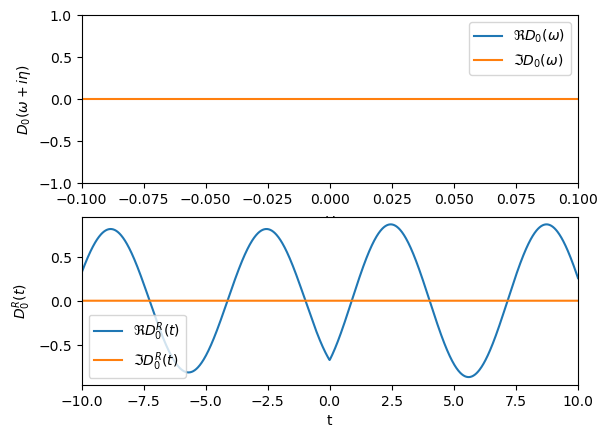

In [11]:
fig,ax = plt.subplots(2)

omega0 = np.sqrt(r)
DR_free_omega = 1./(r - (omega+1j*eta)**2)
#DR_free_omega_left = 0.5/omega0 * (1/(omega +1j*eta + omega0 ))
#DR_free_omega_right = 0.5/omega0 * (-1/(omega + 1j*eta - omega0))
#DR_free_omega = DR_free_omega_left + DR_free_omega_right
DR_free_t = (0.5/np.pi)*freq2time(DR_free_omega,M,dt)
#DR_free_t_left = (0.5/np.pi)*freq2time(DR_free_omega_left,M,dt)
#DR_free_t_right = (0.5/np.pi)*freq2time(DR_free_omega_right,M,dt)
#DR_free_t= DR_free_t_left + DR_free_t_right

ax[0].plot(omega,np.real(DR_free_omega), label = r'$\Re{D_0(\omega)}$')
ax[0].plot(omega,np.imag(DR_free_omega), label = r'$\Im{D_0(\omega)}$')
ax[0].set_xlabel(r'$\omega$')
ax[0].set_ylabel(r'$D_0(\omega+i\eta)$')
ax[0].set_xlim(-0.1,0.1)
ax[0].set_ylim(-1,1)
ax[0].legend(loc = 'upper right')

ax[1].plot(t,np.real(DR_free_t), label = r'$\Re D^R_0(t)$')
ax[1].plot(t,np.imag(DR_free_t), label = r'$\Im D^R_0(t)$')
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$D_0^R(t)$')
ax[1].set_xlim(-10,10)
ax[1].legend(loc = 'lower left')

''' But wait, shouldn't D_R(t) also be proportional to \theta(t)????? : suspicious '''

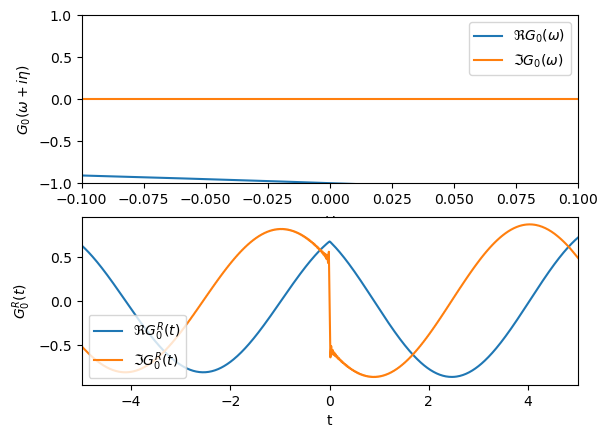

In [12]:
fig,ax = plt.subplots(2)

GR_free_omega = 1./(omega+1j*eta - r)
GR_free_t = (0.5/np.pi)*freq2time(GR_free_omega,M,dt)

#Gforw = GR_free_t[M:]
#Grev = GR_free_t[:M]
#Grec = np.concatenate((-1.0*Grev,Gforw))

ax[0].plot(omega,np.real(GR_free_omega), label = r'$\Re{G_0(\omega)}$')
ax[0].plot(omega,np.imag(GR_free_omega), label = r'$\Im{G_0(\omega)}$')
ax[0].set_xlabel(r'$\omega$')
ax[0].set_ylabel(r'$G_0(\omega+i\eta)$')
ax[0].set_xlim(-0.1,0.1)
ax[0].set_ylim(-1,1)
ax[0].legend(loc = 'upper right')


ax[1].plot(t,np.real(GR_free_t), label = r'$\Re G^R_0(t)$')
ax[1].plot(t,np.imag(GR_free_t), label = r'$\Im G^R_0(t)$')
#ax[1].plot(t,np.real(Grec), label = r'$\Re Grec(t)$')
#ax[1].plot(t,np.imag(Grec), label = r'$\Im Grec(t)$')
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$G_0^R(t)$')
ax[1].set_xlim(-5,5)
ax[1].legend(loc = 'lower left')

In [13]:
DRomega[M:M+2]

array([ 0.49461181-7.97313759e-09j, -0.08785376+3.69830027e-01j])